### Analysis of the axpby and dot routines

In [1]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Here is a list of all the file(ending)s and an indication of the corresponding architecture and number of nodes. Also we define some utilities that we use in our plot further down:

In [2]:
#(hardware name, number of nodes)
filesD = {
         'knl_mpi1':('knl',1), 'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
         'skl_mpi1':('skl',1), 'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
         'i5':('i5',1),
         'p100_mpi1':('p100',1), 'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
         'v100_mpi1':('v100',1), 'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
         'gtx1060':('gtx1060',1)
                      }
# order by number of nodes to make labeling easier further down
files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
# count number of 1 nodes in dict
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1
arch = {'knl':(cm.Greens,450,0.7),'skl':(cm.Greys,205,0.7),'p100':(cm.Blues,550,0.7),'v100':(cm.Purples,850,0.7),
        'i5':(cm.Wistia,30,0.5),'gtx1060':(cm.Oranges,157,0.5)}
intens={1:0.8, 2:0.6, 4:0.4}

In the next box we read in all files defined previously and take only the axpby and dot columns. For these we compute the average bandwidth for each row and then plot.

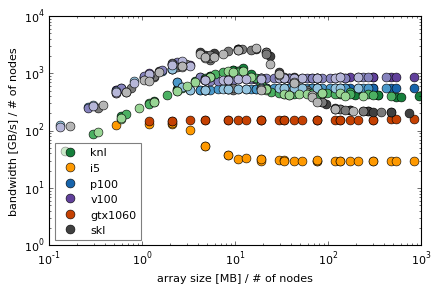

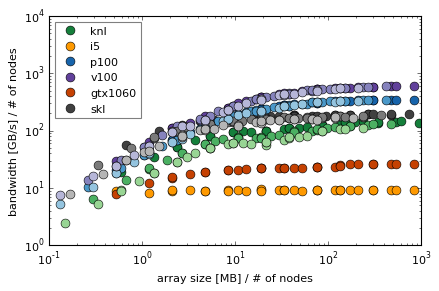

In [3]:
for q in ('axpby','dot'):
    fig,ax=plt.subplots(1,1,figsize=(6,3.7),dpi= 80, facecolor='w', edgecolor='k')
    for f, v in files.items():  
        #read in csv file
        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        bw = df[['n','Nx','Ny','size']]
        bw = bw.assign(axpby = df['size']/1000*3/df['axpby'])
        bw = bw.assign(dot = df['size']/1000*2/df['dot'])
        #compute mean and standard derivation of 'same' groups 
        bw=bw.groupby(['n', 'Nx','Ny','size']).agg(['mean', 'std'])
        bw=bw.reset_index(level=['n','Nx','Ny','size'])
        bw=bw.sort_values(by='size')
        #print(f,v[0], matplotlib.colors.to_rgb(color))
        bw[q].plot(ax=ax,color=arch[v[0]][0](intens[v[1]]), marker='o',ls='',markeredgecolor='k',
                    x=bw.loc[:,'size'],y='mean',markersize=8,label=v[0])#+' ('+str(arch[v[0]][1])+')')
    plt.xlabel('array size [MB] / # of nodes')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-1,1e3)
    #for k,v in arch.items():
    #    if q=='axpby' : 
    #        plt.axhline(y=v[1],xmin=v[2],xmax=1,color=v[0](1.0),lw=2)

    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]
    if q=='dot':
        plt.legend(handles, labels, loc='upper left',numpoints=1,
                   fontsize='medium',framealpha=0.5)
        plt.ylabel('bandwidth [GB/s] / # of nodes')
        plt.ylim(1,1e4)

    else:
        plt.legend(handles, labels, loc='lower left',numpoints=1,
                   fontsize='medium',framealpha=0.5)
        plt.ylabel('bandwidth [GB/s] / # of nodes')
        plt.ylim(1,1e4)

    #plt.title(q)
    plt.savefig(q+'.pdf',bbox_inches='tight')

intensity marks number of nodes: darkest 1 node, ligthest 4 nodes

##### Conclusions
- the linear increase in bandwidth with size is the latency dominated regime 
$$ \frac{b}{\text{GB/s}} = \left(\frac{t_{lat}}{\text{ms}}\right)^{-1} \left(\frac{s}{\text{MB}}\right) $$ where $b$ is the bandwidth and $s$ is the size. The slope (the intercept in the loglog plot) therefore is the inverse latency in milliseconds.
- for dot GPU has high latency because it sends result to CPU, but why the KNL card?
- GPUs have smallest latencies in axpby, KNL highest
- bandwidth dominated regime starts at around 10MB 
- especially in Skylake the cache effect in axpby is obvious: without communication vector just stays in cache of size 33MB
- total problem size on one node in both axpby and dot is 2 * array size
- size normalization for MPI reveals that it is indeed the single node bandwidth that counts, (if we simply divided bandwidth by # of nodes, we would falsely attribute performance loss to MPI communication)
- for small sizes the communication overhead in MPI becomes visible
- Skylake achieves almost 100% efficiency in dot product, followed by Tesla cards P100 and V100